# W200 Project 2
## Data analysis: Mapping the Heating Data of Cities on a Map

### 1. Introduction
This notebook attempts to use geopandas to visualize the heating pattern across cities.  If time permits, exploration on merging with UN city-based data will be explored.

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# loads the "largest_city_list.csv" and "metadata_largest_city.csv"
city_list = pd.read_csv('data_files/largest_city_list.csv')
metadata = pd.read_csv('data_files/metadata_largest_city.csv', index_col = 'City')

# a fucntion to load the 3 523 individual city csv:
def retrieve_city_data():
    '''
    Reads in all city based csv files.  Run at start of session by default.
    '''
    city_data = {}
    
    for city in city_list.city:
        filename = city + '.csv'
        city_data.update({city: pd.read_csv(filename)})
    
    return city_data

### 2. Preparing the data
This is basically repeating the steps done for Part 3 of the original notebook file analyzing regional heating patterns.

In [14]:
# base data with all needed columns included
base_data = metadata.copy()
base_data['Warming_since_1960'] = city_list.set_index('city').warming_since_1960

# adds the north/south hemisphere categorization
base_data['Hemisphere'] = 'north'
base_data.loc[base_data.Latitude < 0, 'Hemisphere'] = 'south'

# adds the tropical/sub-tropical/temperate/frigid zones categorization
base_data['Climate_zone'] = 'tropical'
base_data.loc[(base_data.Latitude < -23.43644) | (base_data.Latitude > 23.43644), 'Climate_zone'] = 'sub-tropical'
base_data.loc[(base_data.Latitude < -35) | (base_data.Latitude > 35), 'Climate_zone'] = 'temperate'
base_data.loc[(base_data.Latitude < -66.5) | (base_data.Latitude > 66.5), 'Climate_zone'] = 'frigid'

# adds the natural time zones.
base_data['Natural_time_zone'] = 'UTC'
for i in range(12):
    base_data.loc[(base_data.Longitude < (-7.5 - 15 * i)), 'Natural_time_zone'] = 'UTC-' + str(i+1)
    base_data.loc[(base_data.Longitude > (7.5 + 15 * i)), 'Natural_time_zone'] = 'UTC+' + str(i+1)
    
print("Showing the value counts of the added columns")
for column in ['Hemisphere', 'Climate_zone', 'Natural_time_zone']:
    print(f"\nThe following is the value counts of column {column}:")
    print(f"{base_data[column].value_counts()}")

Showing the value counts of the added columns

The following is the value counts of column Hemisphere:
north    2907
south     616
Name: Hemisphere, dtype: int64

The following is the value counts of column Climate_zone:
tropical        1376
temperate       1249
sub-tropical     896
frigid             2
Name: Climate_zone, dtype: int64

The following is the value counts of column Natural_time_zone:
UTC+8     395
UTC+5     385
UTC       320
UTC+2     306
UTC+1     295
UTC+7     295
UTC-5     235
UTC+9     201
UTC-3     184
UTC+3     181
UTC+6     171
UTC-6     127
UTC-7     115
UTC-8      89
UTC-4      79
UTC+4      64
UTC-1      36
UTC-2      18
UTC+10     16
UTC+12      7
UTC+11      3
UTC-10      1
Name: Natural_time_zone, dtype: int64


### 3. Map showing temperature rise since 1960
(i) Plotting the temperature rise (warming since 1960) for cities using a map.

In [15]:
# loading the data frame to geo-pandas

gdf = gpd.GeoDataFrame(base_data.Warming_since_1960, geometry=gpd.points_from_xy(base_data.Longitude, base_data.Latitude))

gdf

,Warming_since_1960,geometry
City,,
A Coruña,2.37,POINT (-8.73000 42.59000)
Aachen,2.83,POINT (6.34000 50.63000)
Aalborg,2.84,POINT (10.33000 57.05000)
Aba,1.55,POINT (8.07000 5.63000)
Abadan,2.89,POINT (48.00000 29.74000)
...,...,...
Zouxian,2.23,POINT (117.35000 36.17000)
Zunyi,0.84,POINT (106.36000 28.13000)
Zurich,2.85,POINT (8.29000 47.42000)


Text(0.5, 1.0, 'Global Warming since 1960 in Largest Cities')

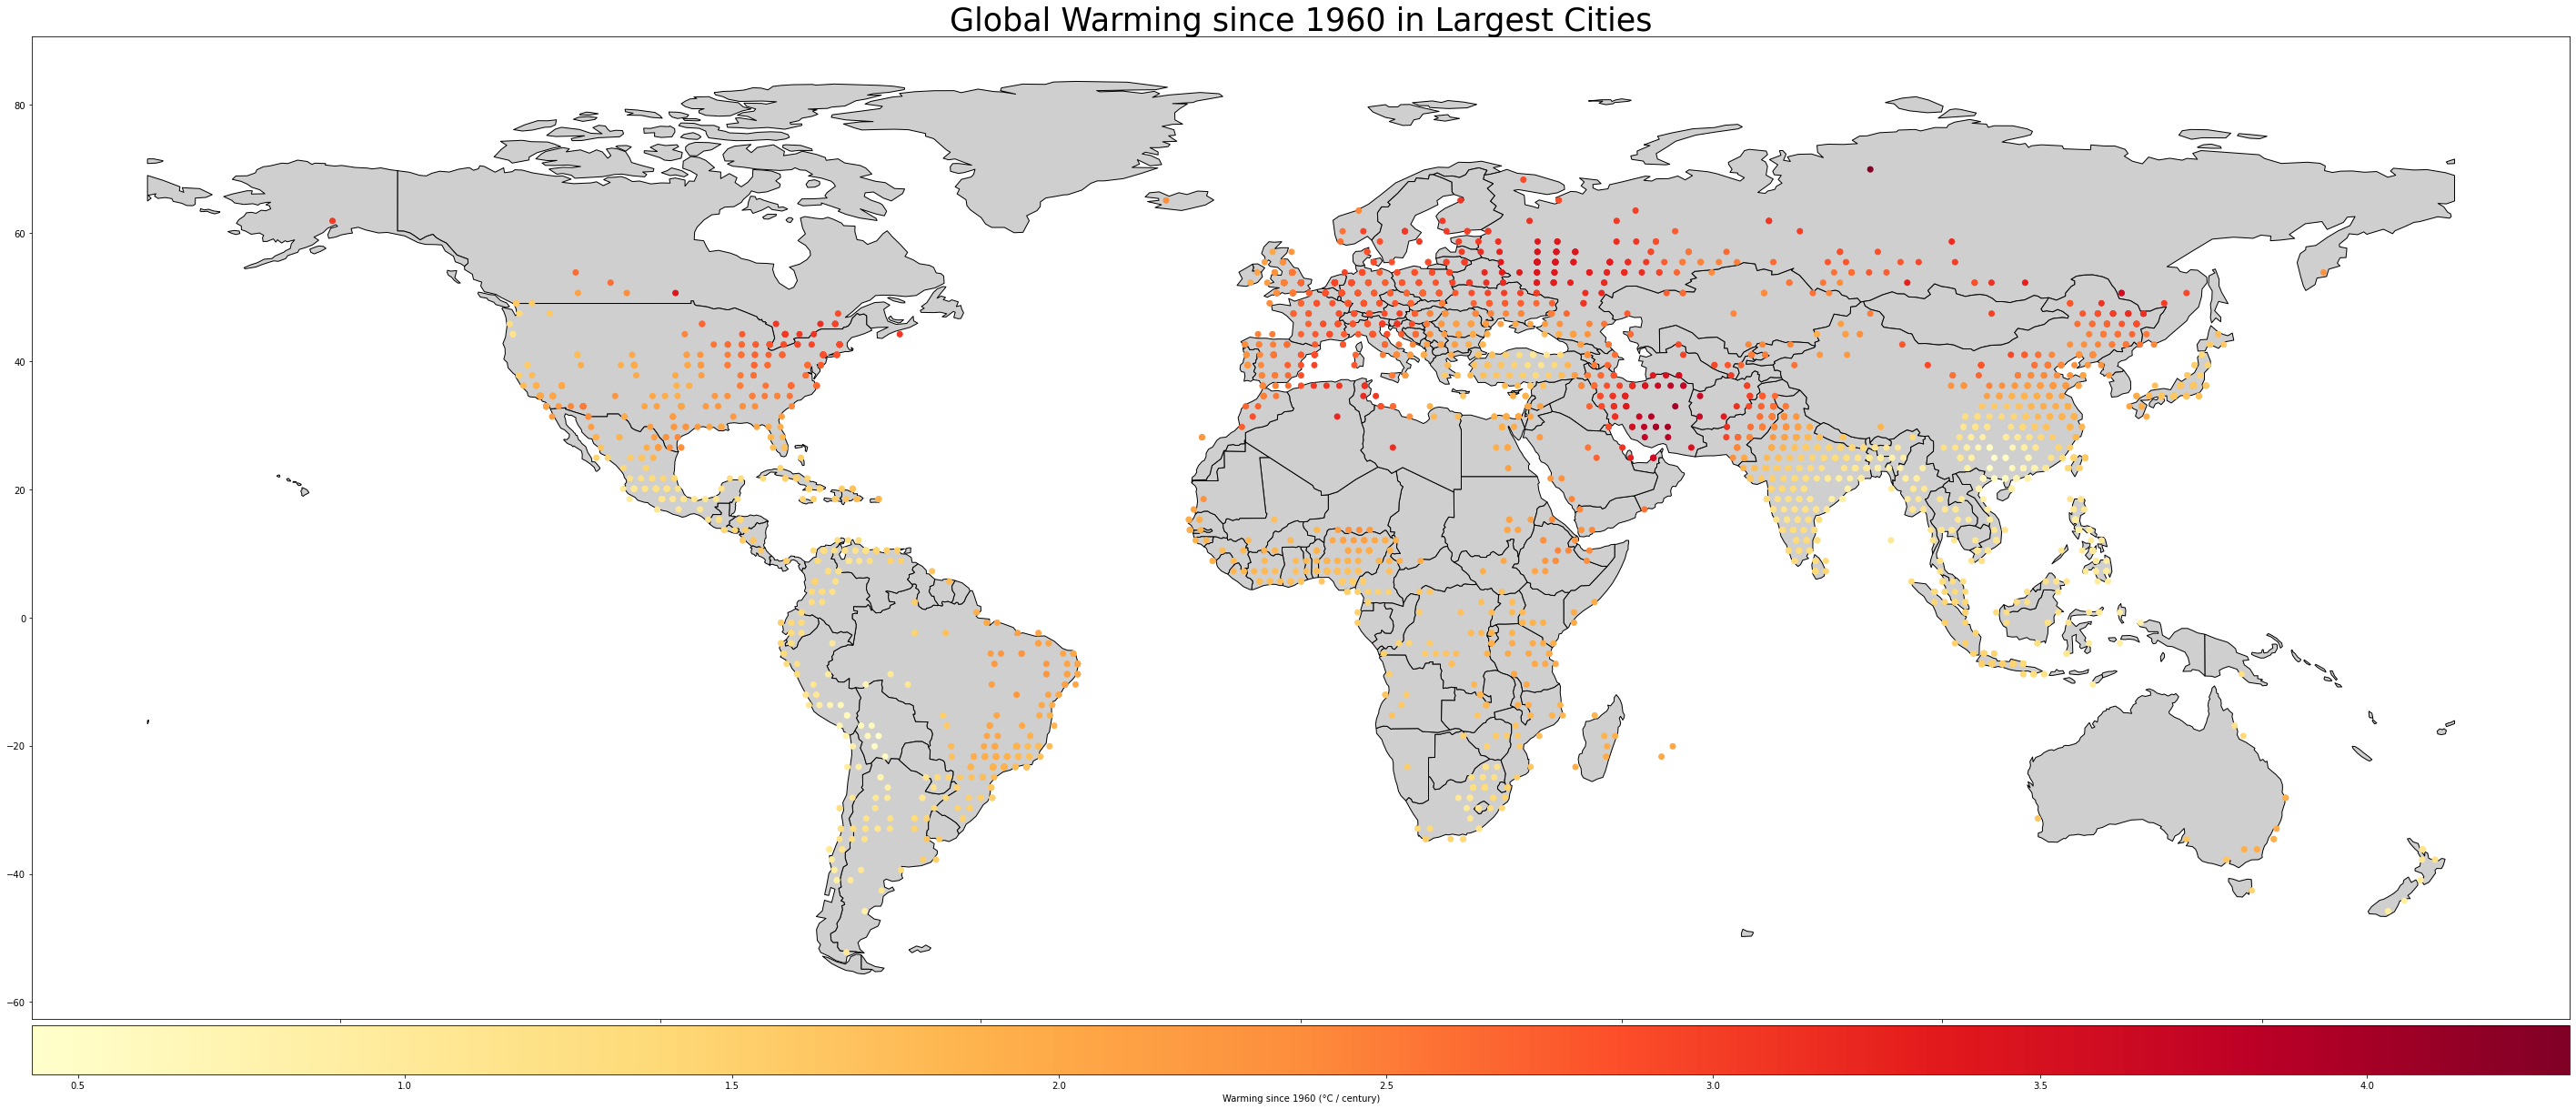

In [16]:
# plotting the graph

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent != 'Antarctica'].plot(color="#cfcfcf", edgecolor='black', figsize=(50, 50))

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

gdf.plot(ax=ax, column='Warming_since_1960', cmap='YlOrRd', legend=True, cax=cax, 
         legend_kwds={'label': "Warming since 1960 (°C / century)",
                      'orientation': "horizontal",
                      'shrink': 0.9})

ax.set_title("Global Warming since 1960 in Largest Cities", fontsize=35)

### 4. Bonus content: Which cities will reach uninhabitable temperatures based on current trend?
The UN has prepared under its World Urbanization Prospects 2018 project (https://population.un.org/wup/Download/) various datasets showing the location and population size of the largest cities in the world, along with some forecast on future population growth.

The idea of this section is to look at the current number of cities in the Berkeley Earth dataset that already has uninhabitable temperatures (defined for simplicity as having an average temperature of any month reaching 35 degrees Celsius or above) currently, as well as the projected temperature that each month may reach based on the current warming trend for that city in a number of selected future years. Then, we look at those cities and see what their population at that time will be.  

This will give us some very initial glimpse on what the climate refugee problem can look like.  Of course, looking only at average monthly temperatures is going to be considering only a very small subset of the problem, and it should also be noted that we are likely going to be underestimating the issue since, as temperature rises, more people will probably be heading towards cities which exacerbates the problem at those cities if the cities themselves are reaching uninhabitable temperature levels (see for example this reporting by the Economist: https://www.economist.com/briefing/2021/07/24/three-degrees-of-global-warming-is-quite-plausible-and-truly-disastrous?)

In [17]:
# First, let's import the UN data, which captures the name, country, population of some 1800 cities with over 300k population.
# The first 15 rows are junk
pop_df = pd.read_excel('data_files/WUP2018-F12-Cities_Over_300K_modified.xls', header=16)
pop_df

,Index,Country Code,Country or area,City Code,Urban Agglomeration,Note,Latitude,Longitude,1950,1955,...,1990,1995,2000,2005,2010,2015,2020,2025,2030,2035
0,1,4,Afghanistan,20001,Herat,NaN,34.348170,62.199670,82.468,85.751,...,183.465,207.190,233.991,275.678,358.691,466.703,605.575,752.910,897.041,1057.573
1,2,4,Afghanistan,20002,Kabul,NaN,34.528887,69.172460,170.784,220.749,...,1549.320,1928.694,2401.109,2905.178,3289.005,3723.543,4221.532,4877.024,5737.138,6760.500
2,3,4,Afghanistan,20003,Kandahar,NaN,31.613320,65.710130,82.199,89.785,...,233.243,263.395,297.456,336.746,383.498,436.741,498.002,577.128,679.278,800.461
3,4,4,Afghanistan,20004,Mazar-e Sharif,NaN,36.709040,67.110870,30.000,37.139,...,135.153,152.629,172.372,206.403,283.532,389.483,532.689,681.531,816.040,962.262
4,5,8,Albania,20005,Tiranë (Tirana),NaN,41.327500,19.818890,84.513,106.932,...,247.270,287.950,335.336,371.803,408.697,449.298,493.712,535.702,565.301,581.626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,1856,894,Zambia,23277,Lusaka,NaN,-15.413374,28.277148,31.169,53.237,...,757.433,901.621,1073.299,1357.143,1722.879,2187.180,2774.133,3470.866,4266.517,5182.669
1856,1857,894,Zambia,23279,Ndola,NaN,-12.958670,28.636590,30.621,47.145,...,333.984,353.337,373.498,408.948,448.793,492.519,542.495,628.595,762.477,925.726
1857,1858,716,Zimbabwe,22510,Bulawayo,NaN,-20.150000,28.583330,91.635,94.495,...,570.046,637.016,664.560,669.878,658.235,646.800,638.188,668.949,753.306,874.479
1858,1859,716,Zimbabwe,22511,Chitungwiza,NaN,-18.012740,31.075550,38.645,48.777,...,248.923,287.986,312.294,332.557,349.406,367.101,386.452,419.611,475.422,552.027


In [7]:
# The problem is how to match the city names of the UN data with our own.
# Due to the presence of translation issues, use of normalized alphabets, etc., the idea is to first try to match the name
# and country, and for cities in the UN data (which should be a subset of the Berkeley Earth Data except for a few odd cases
# where a major city has no weather station nearby) that can't find a matching name in our data, we can use the latitude
# longitude to find a nearby station in our data to match the city.
import math
import difflib

def distance(lat1, lon1, lat2, lon2):
    '''
    Returns the distance between two points based on the Latitude (lat1, lat2) and Longitudes (lon1, lon2).
    
    Unit of distance returned is in km.
    
    Idea and parameters based on Kite.
    '''
    # radius of the Earth
    R = 6373.0
    
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))  
    return R * c

In [19]:
# To merge the relevant colummns of city_list to metadata

metadata = metadata.reset_index()
metadata['Country'] = city_list.country
metadata['Warming_since_1960'] = city_list.warming_since_1960
metadata = metadata.set_index('City')
metadata.columns

Index(['Latitude', 'Longitude', 'Neighborhood_water_percent', 'Baseline_temp',
       'Baseline_temp_uncertainty', 'Jan_temp', 'Jan_uncertainty', 'Feb_temp',
       'Feb_uncertainty', 'Mar_temp', 'Mar_uncertainty', 'Apr_temp',
       'Apr_uncertainty', 'May_temp', 'May_uncertainty', 'Jun_temp',
       'Jun_uncertainty', 'Jul_temp', 'Jul_uncertainty', 'Aug_temp',
       'Aug_uncertainty', 'Sep_temp', 'Sep_uncertainty', 'Oct_temp',
       'Oct_uncertainty', 'Nov_temp', 'Nov_uncertainty', 'Dec_temp',
       'Dec_uncertainty', 'Over_300k', 'Country', 'Warming_since_1960'],
      dtype='object')

In [21]:
# A small script for preparing cleaning up the excel file.
# Idea is to match the cities that show up in both the UN and Berkeley Earth datasets
# Then for those without exact match, use difflib to locate a city with name sufficiently similar and also
# located sufficiently close.
# Finally, manually review the remaining cities for cases where:
#   (i) another city very close to it (<= 25, 50 and then relaxed step-by-step to 150 km); and
#   (ii) not otherwise pointed to by another city.

# Since the UN dataset uses a different way to denote cities (e.g. Doha is split into two cities, some cities uses
# old administrative delineration/name, etc, the goal is to, as far as possible, find a closely enough city from 
# the Berkeley Earth data point to provide a look at how the population near that location will be affected.

# Givn the way this is done, the actial number of cities in the UN data that is not represented on the subsequent map plot
# is equal to the length of the "dump" list, i.e. 133 cities.  Among the remaining 1 727 cities, they will be plotted as
# 1 459 data points on the subsequent map.

conversion_dict = {}
to_review = {}
dump = []
metadata_copy = metadata.copy()
for i in range(len(pop_df)):
    found = False
    country, city = pop_df.iat[i, 2], pop_df.iat[i, 4]
    if city in metadata.index and (metadata.at[city, 'Country'] == country):
        conversion_dict[city] = city
        metadata_copy = metadata_copy.drop(city)
    else:
        list_similar_names = sorted(list(metadata.index[metadata.Country == country]), 
                                    key=lambda x: difflib.SequenceMatcher(None, x, city).ratio(),
                                    reverse=True)
        for j in range(len(list_similar_names)):
            alt_name = list_similar_names[j]
            dist = distance(metadata.at[alt_name, 'Latitude'],
                            metadata.at[alt_name, 'Longitude'], 
                            pop_df[pop_df['Urban Agglomeration'] == city].iat[0, 6],
                            pop_df[pop_df['Urban Agglomeration'] == city].iat[0, 7])
            if dist <= 100:
                if difflib.SequenceMatcher(None, alt_name, city).ratio() >= 0.5:
                    conversion_dict[city] = alt_name
                elif difflib.SequenceMatcher(None, alt_name, city).ratio() >= 0.1 and dist <= 50:
                    to_review[city] = alt_name
                found = True
                break        
        if not found:
            dump.append((city, country))
            
            
to_review_2 = {}
for city, country in dump:
    best_dist = 9999
    best_city = ''
    for alt_name in metadata[metadata.Country == country].index:
        if alt_name in conversion_dict.values():
            continue
        dist = distance(metadata.at[alt_name, 'Latitude'],
                        metadata.at[alt_name, 'Longitude'], 
                        pop_df[pop_df['Urban Agglomeration'] == city].iat[0, 6],
                        pop_df[pop_df['Urban Agglomeration'] == city].iat[0, 7])
        if dist < best_dist:
            best_dist = dist
            best_city = alt_name
    if best_dist <= 150:
        to_review_2[city] = (best_city, country, best_dist)     

Manual adjustments made:

The general idea is to make use of the "to_review" list generated from above, and only include a conversion
if the converted city name has not been taken up by another city from the UN list.

Batch 1
- 'Neuquén-Plottier-Cipolletti': 'Neuquen'
- 'Al-Manamah (Manama)': 'Manama'
- 'Rupganj': 'Narayanganj'
- 'Kitchener-Cambrigde-Waterloo': 'Kitchener'
- 'Al-Qahirah (Cairo)': 'Cairo'
- 'As-Suways': 'Suez'
- 'Banjul': 'Brikama'
- 'Muenster (Westfalen)': 'Münster'
- 'Lucknow': 'Lakhnau'
- 'Makassar (Ujung Pandang)': 'Makasar',
- 'Tel Aviv-Yafo (Tel Aviv-Jaffa)': 'Tel Aviv-Yafo'
- 'Chukyo M.M.A. (Nagoya)': 'Nagoya',
- 'Semipalatinsk': 'Semey',
- 'Ust-Kamenogorsk': 'Öskemen',
- 'Ciudad de México (Mexico City)': 'Mexico',
- 'Fès': 'Fez',
- 'Ciudad de Panamá (Panama City)': 'Panamá',
- 'Ad-Dawhah (Doha)': 'Doha',
- 'Sanliurfa': 'Urfa',
- 'Ash-Shariqah (Sharjah)': 'Sharjah',
- 'Southampton/Portsmouth (South Hampshire)': 'Southampton',
- 'Yorkshire': 'York'
- 'El Djazaïr  (Algiers)': 'Algiers'
- 'Wien (Vienna)': ('Vienna', 'Austria', 107.66004929221532),

Batch 2:
- 'San Miguel de Tucumán': 'Tucuman'
- 'Mysore': 'Maisuru'
- 'Kinki M.M.A. (Osaka)': 'Kishiwada'
- 'Aktyubinsk': 'Aqtöbe'

Bacth 3:
- 'San Salvador de Jujuy': 'Jujuy'
- 'León de los Aldamas': 'León2'

Batch 4:
- "Ji'an, Jiangxi": 'Jian',
- "Ji'nan, Shandong": 'Jinan'
- 'Yichun, Heilongjiang': 'Yichun2'
- 'Dazhou': 'Daxian'

Batch 5A: These are not about cities being similar, 
but that their distance is really close (<= 25 km) and are in the same country
- 'Mymensingh': 'Sirajganj'
Batch 5B: Cities that are close (25 km < x <= 50 km) and are in the same country
- 'Dengzhou': 'Laohekou'
- 'Gaoan': 'Linchuan',
- 'Hechi': 'Jinchengjiang',
- 'Tangshan, Hebei': 'Tanggu',
- 'Avignon': 'Aix-en-Provence',
- 'Bandar Lampung': 'Pringsewu',
- 'Nola': 'Foggia',
- 'Gwagwalada': 'Suleja',
- 'Igbidu': 'Amaigbo',
- 'Ijebu-Ode': 'Ilobu',
- 'Rahim Yar Khan': 'Khanpur'
- 'Victorville-Hesperia-Apple Valley': 'Moreno Valley'

Batch 6 Manual Adjustments (based on distance of 150 km):
- 'Comilla': 'Chandpur'
- 'Sylhet': 'Bhairab Bazar'
- 'Hamilton': 'Hamilton1'
- 'Québec': 'Quebec'
- 'Chuxiong': 'Haikou1'
- 'Daqing': 'Anda'
- 'Danyang': 'Zhaoyang'
- 'Enshi': 'Wanxian'
- 'Fuqing': 'Bantou'
- 'Hanchuan': 'Guangshui'
- 'Kaiping': 'Sanbu'
- 'Kuerle': 'Korla'
- 'Lishui, Zhejiang': 'Huangyan'
- 'Meizhou' 'Chenghai'
- 'Qidong': 'Jiangyin2'
- 'Quzhou': 'Wuning'
- 'Rugao': 'Yizheng'
- 'Shanwei': 'Anbu'
- 'Songyuan': 'Yongan'
- 'Suzhou, Anhui': 'Suzhou1'
- 'Tonghua': 'Huadian'
- 'Xiangyang': 'Xiangfan'
- 'Yulin, Guangxi': 'Liancheng'
- 'La Habana (Havana)': 'Matanzas'
- 'Marseille-Aix-en-Provence': 'Nîmes',
- 'München (Munich)': 'Augsburg'
- 'Coimbatore': 'Ponnani'
- 'Durg-Bhilainagar': 'Durg'
- 'Kottayam': 'Alappuzha'
- 'Ranipet': ('Neyveli', 'India', 108.70712484433474),
- 'Thoothukkudi (Tuticorin)': 'Nagercoil'
- 'Vellore': 'Ambur'
- 'Kitakyushu-Fukuoka M.M.A.': 'Beppu'
- 'Kochi': 'Akashi'
- 'Karaganda': 'Temirtau'
- 'Blantyre-Limbe': 'Blantyre'
- 'Nuevo Laredo': 'Apodaca'
- 'Dar-el-Beida (Casablanca)': 'Casablanca'
- 'Lisboa (Lisbon)': 'Amadora'
- 'Aguadilla-Isabela-San Sebastian': 'Carolina'
- 'Lop Buri': 'Pak Kret'
- 'Phra Nakhon Si Ayutthaya': 'Khlong Luang'
- 'Lomé': 'Kpalimé'
- 'Kharkiv': 'Pavlohrad'
- 'Makiivka': 'Makiyivka'
- 'Simferopol': 'Yevpatoriya'
- 'Adan (Aden)': 'Aden'
- 'Xingning': 'Donghai'
- 'Hong Kong': 'Shenzhen'
- 'Bunia': 'Butembo'
- 'Bandar Abbas': 'Jiroft'
- 'Nizhny Tagil': 'Nizhniy Tagil'
- 'Al-Raqqa': 'Manbij'
- 'Dimashq (Damascus)': 'Damascus'
- 'Hamah': 'Idlib'
- 'Albany': 'Cambridge2'
- 'Concord': 'Cary'
- 'Indio-Cathedral City-Palm Springs': 'Fontana'
- 'Jackson, Mississippi': 'Jackson'
- 'Provo-Orem': 'Provo'
- 'Scranton': 'Edison', 
- 'St. Louis': 'Saint Louis'

In [28]:
metadata['Over_300k'] = np.where(metadata.index.isin(conversion_dict.values()), 'Y', 'N')
metadata_300K_ciities = metadata[metadata['Over_300k'] == 'Y']
metadata_300K_ciities['High_Temp_Baseline'] = metadata_300K_ciities.iloc[:, 5:28:2].max(axis=1)

for year in (2020, 2040, 2060, 2080, 2100):
    column_name = 'High_Temp_' + str(year)
    metadata_300K_ciities[column_name] = (metadata_300K_ciities['High_Temp_Baseline'] + 
                                          metadata_300K_ciities['Warming_since_1960'] * ((year - 1960) / 100))


<ipython-input-28-5ff915c30371>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_300K_ciities['High_Temp_Baseline'] = metadata_300K_ciities.iloc[:, 5:28:2].max(axis=1)
<ipython-input-28-5ff915c30371>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_300K_ciities[column_name] = (metadata_300K_ciities['High_Temp_Baseline'] +


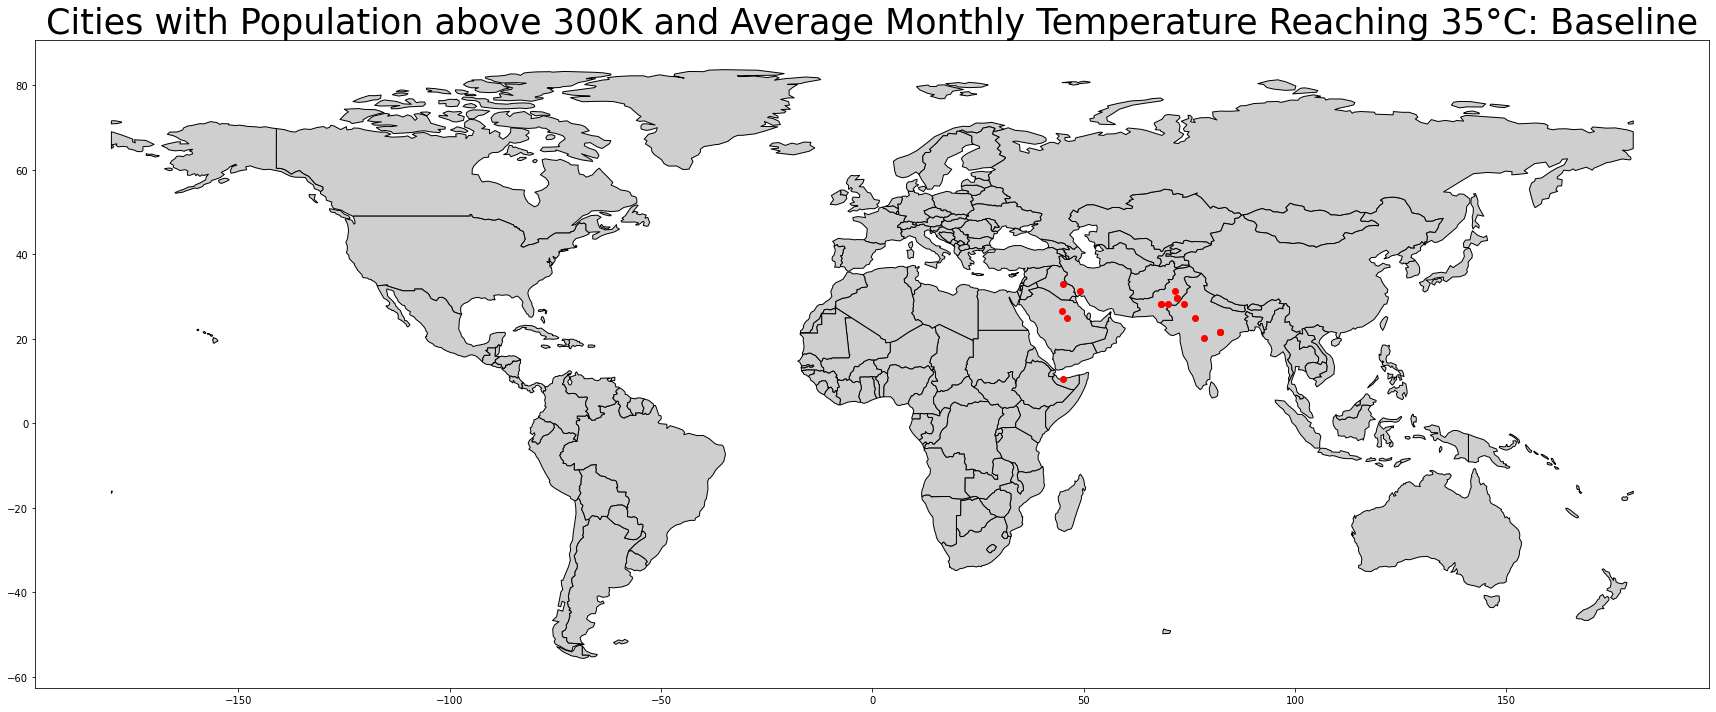

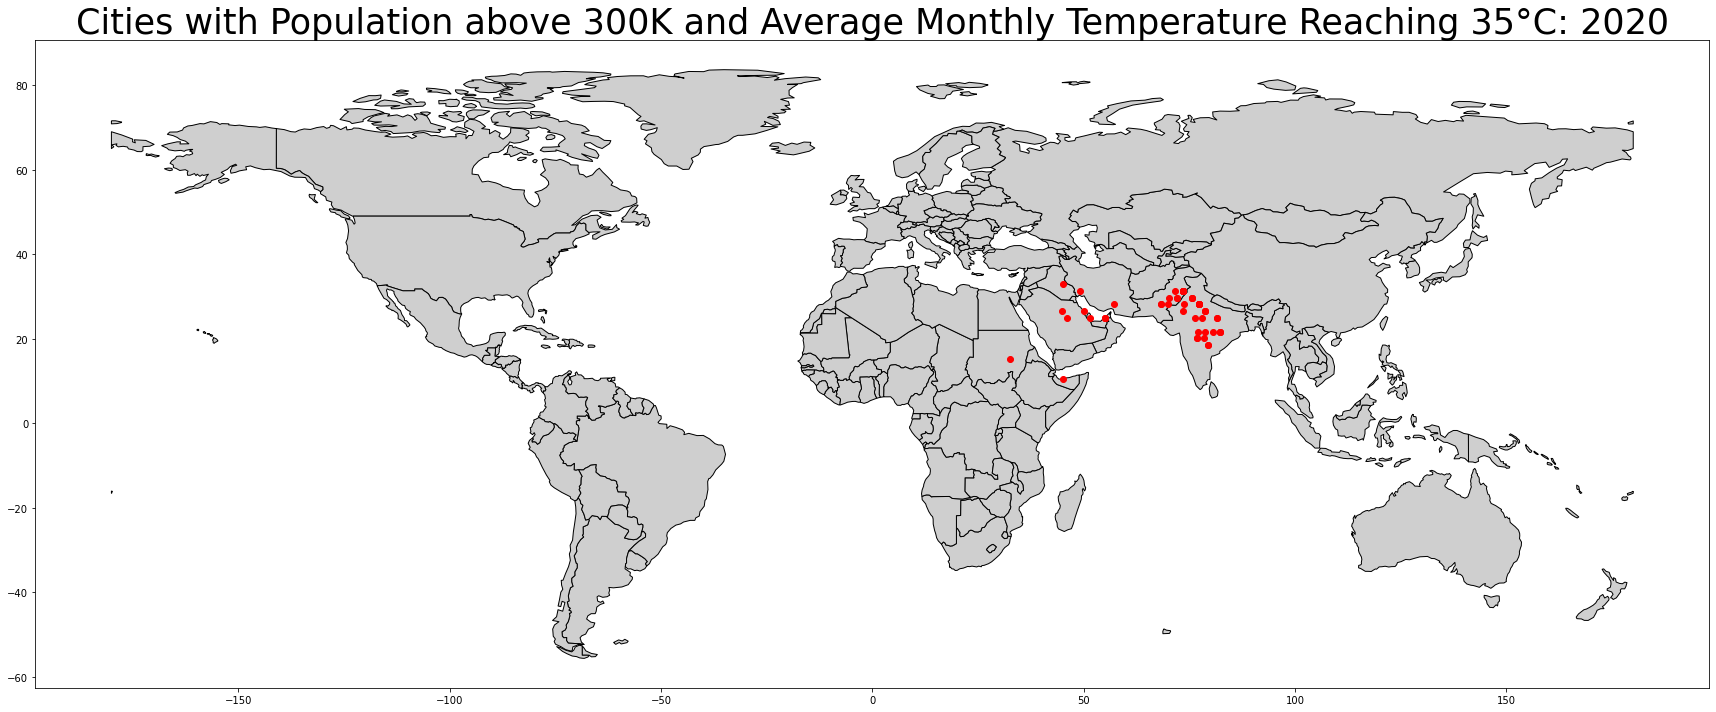

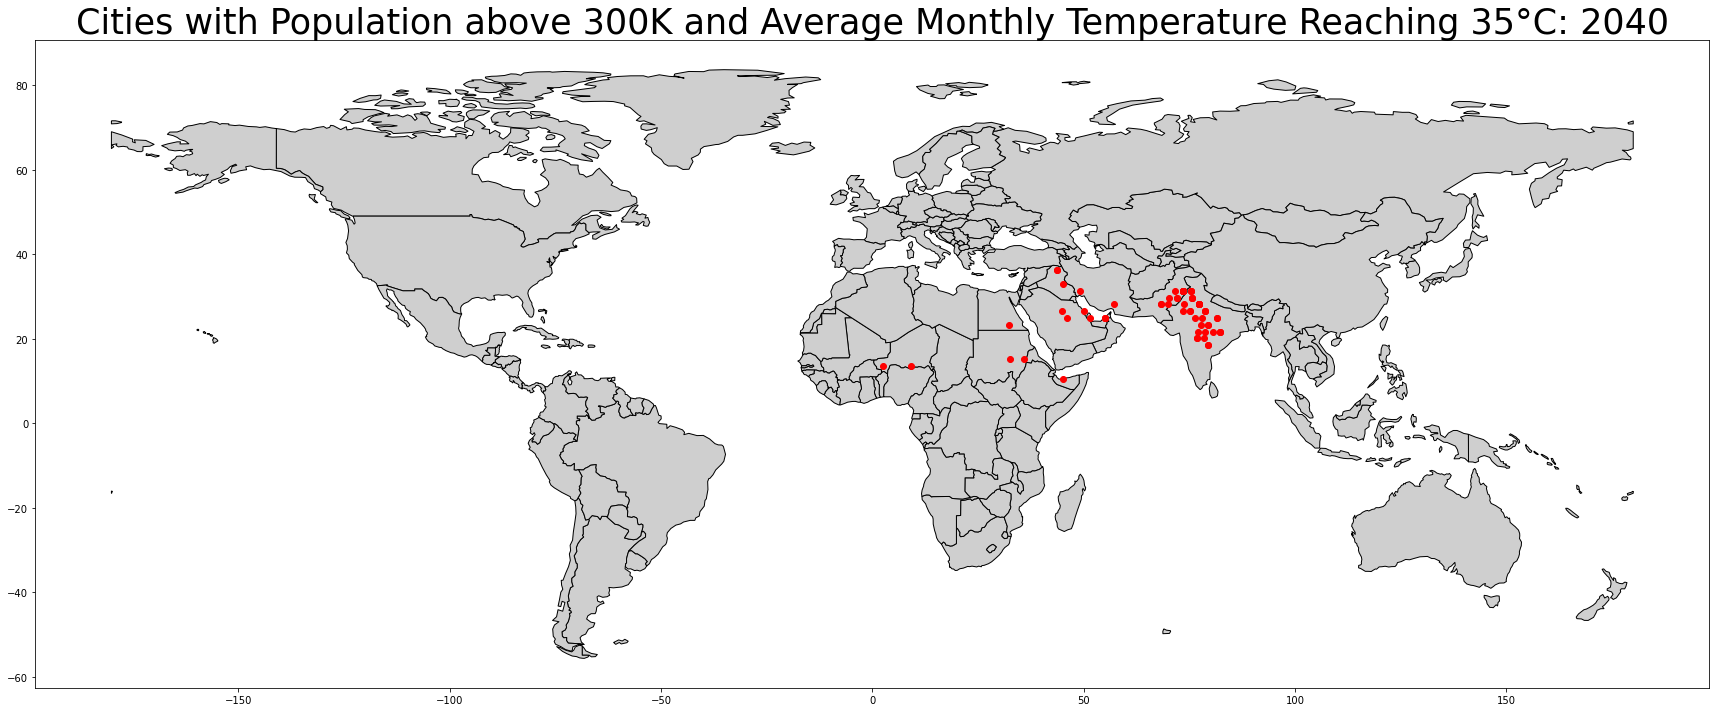

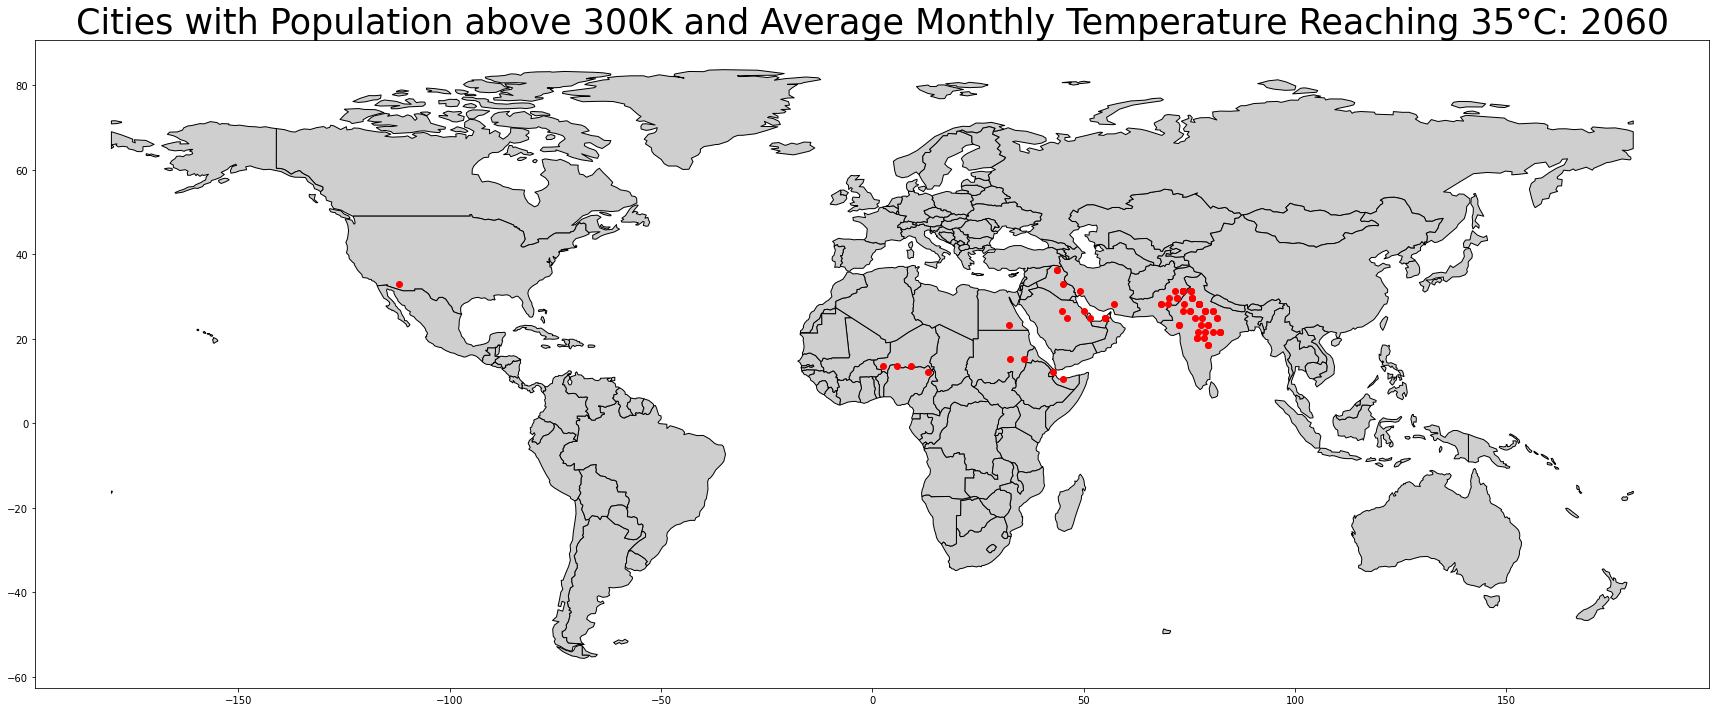

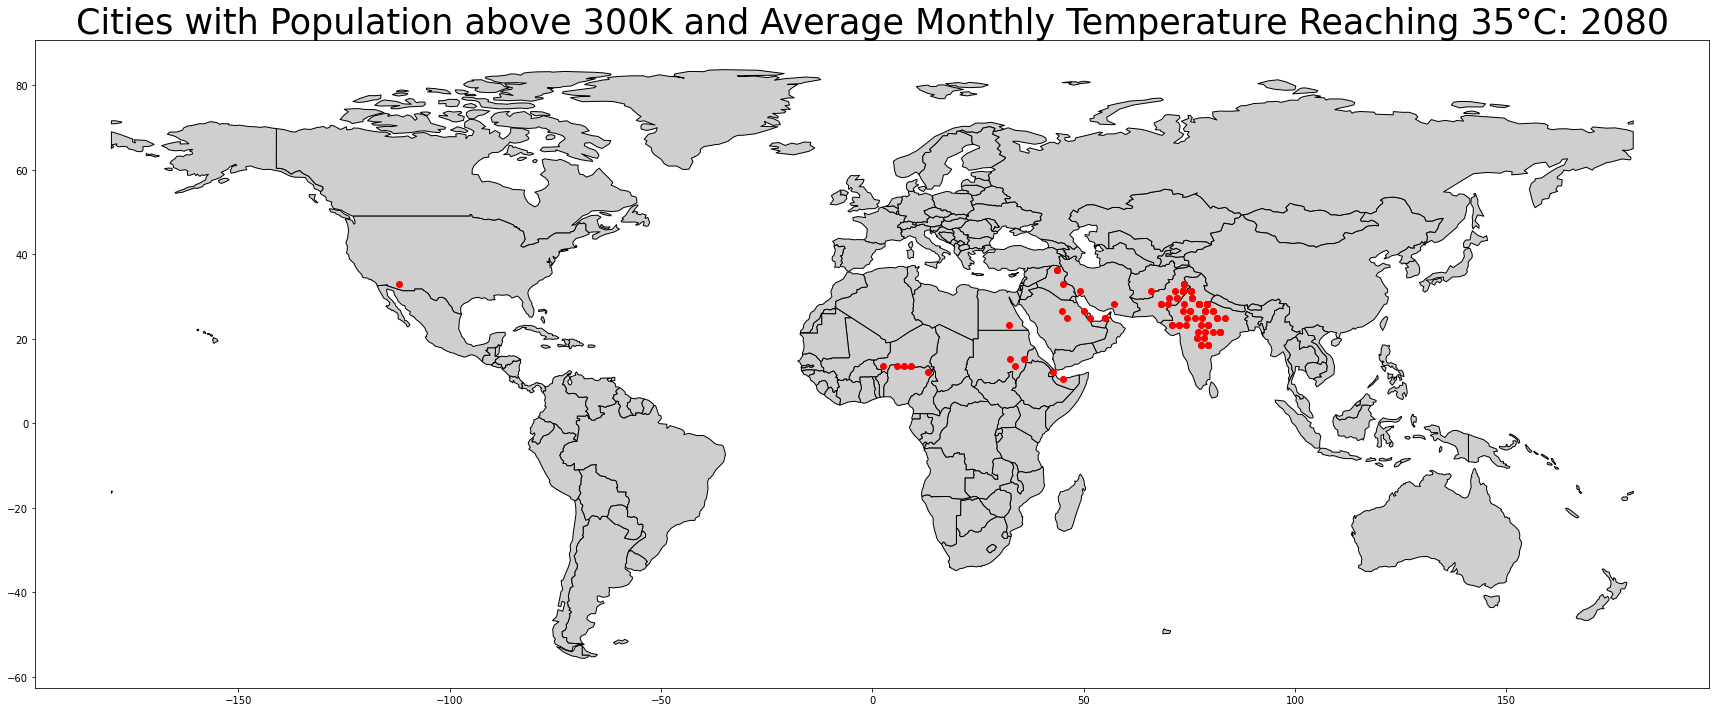

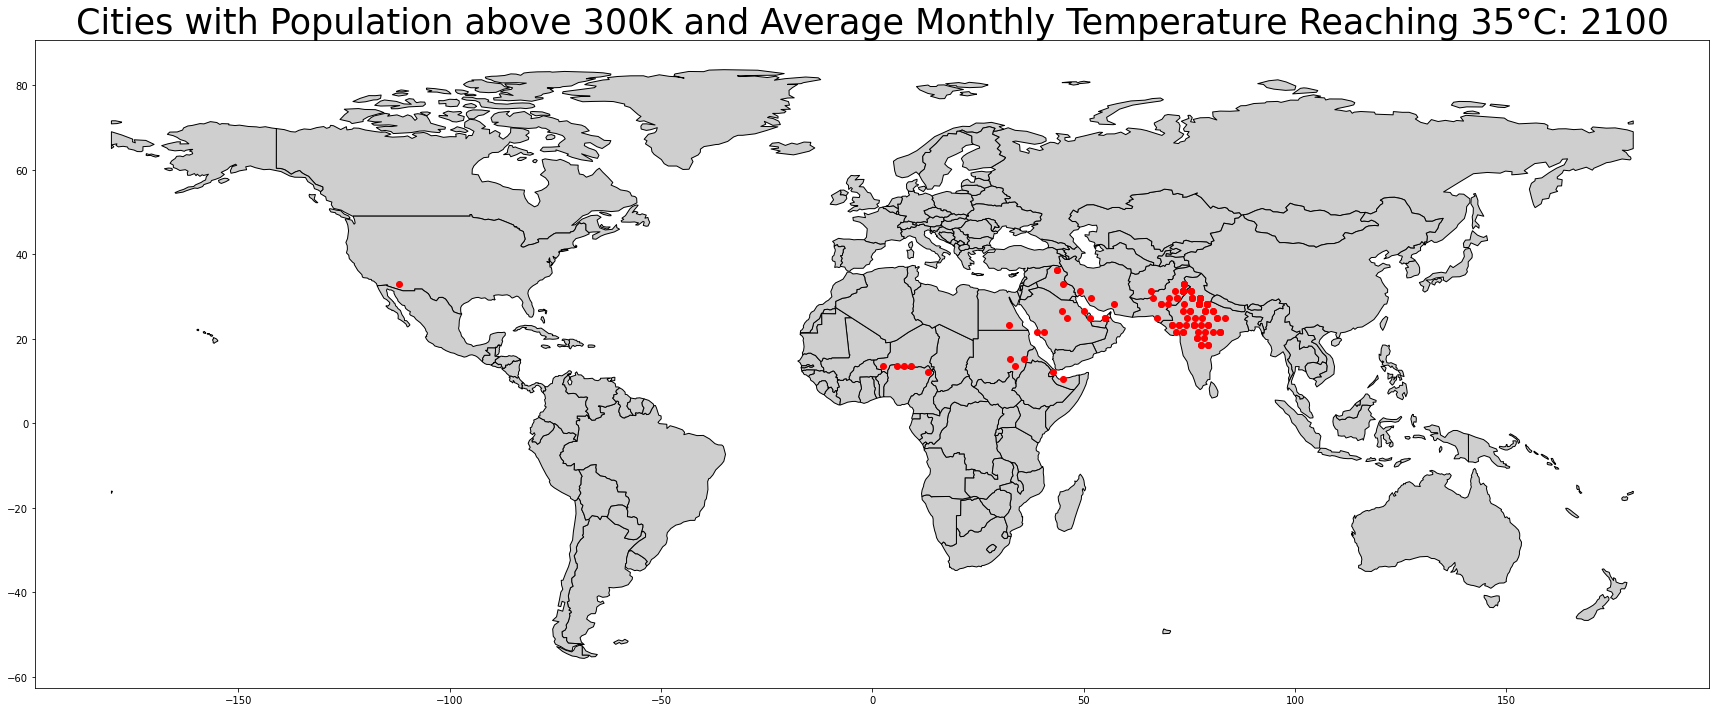

In [29]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax2 = []
for i in range(6):
    ax2.append(world[world.continent != 'Antarctica'].plot(color="#cfcfcf", edgecolor='black', figsize=(30, 30)))
    
i = 0

for column_name in ('High_Temp_Baseline', 'High_Temp_2020', 'High_Temp_2040',
                    'High_Temp_2060', 'High_Temp_2080', 'High_Temp_2100'):
    axes = ax2[i]
    df = metadata_300K_ciities[metadata_300K_ciities[column_name] > 35]
    gdf = gpd.GeoDataFrame(df,
                           geometry=gpd.points_from_xy(df.Longitude,
                                                       df.Latitude))
    gdf.plot(ax=axes, color='red')
    axes.set_title(f"Cities with Population above 300K and Average Monthly Temperature Reaching 35°C: {column_name[10:]}", fontsize=35)
    i += 1


In [33]:
metadata_300K_ciities[(metadata_300K_ciities['High_Temp_2100'] > 35) & (metadata_300K_ciities['Longitude'] < 0)]

,Latitude,Longitude,Neighborhood_water_percent,Baseline_temp,Baseline_temp_uncertainty,Jan_temp,Jan_uncertainty,Feb_temp,Feb_uncertainty,Mar_temp,...,Dec_uncertainty,Over_300k,Country,Warming_since_1960,High_Temp_Baseline,High_Temp_2020,High_Temp_2040,High_Temp_2060,High_Temp_2080,High_Temp_2100
City,,,,,,,,,,,,,,,,,,,,,
Phoenix,32.95,-112.02,0.0,20.91,0.34,10.2,0.64,12.48,0.45,15.12,...,0.7,Y,United States,2.51,32.76,34.266,34.768,35.27,35.772,36.274
